# BTC Predictor

In [2]:
import google.datalab.bigquery as bq
import pandas as pd
import numpy as np
import shutil

In [3]:
%bq tables describe --name [PROJECT-ID].rtda.transformed_tweets

## Pull All Fields from the Table

In [4]:
%bq query -n crypto_predict_query
SELECT average_score, min_score, max_score, count, next_hours_percent_change
FROM `[PROJECT-ID].rtda.transformed_tweets`

## Preview Data

In [5]:
data = crypto_predict_query.execute(query_params={}).result().to_dataframe()
data[:5]

,average_score,min_score,max_score,count,next_hours_percent_change
0,0.251118,-0.72,2.0,152,-0.262524
1,0.249800,-0.72,2.0,50,-0.114193
2,0.389231,-0.60,2.0,52,-0.186434
3,0.256495,-0.60,2.0,97,0.044096
4,0.280857,-1.20,2.0,105,0.478139


## Plot Average Score Against Next Hours Percent Change

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


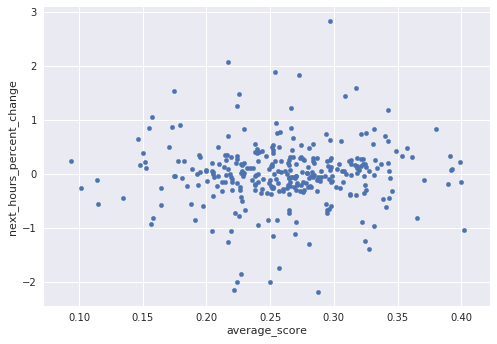

In [6]:
data.plot(kind='scatter', x='average_score', y='next_hours_percent_change')

## Shuffle and Split Data into Predictors, Targets

In [7]:
import tensorflow as tf
import math
shuffled = data.sample(frac=1, random_state=13)
num_predictors = 4

predictors = shuffled.iloc[:,0:num_predictors]
predictors[:5]

targets = shuffled.iloc[:,num_predictors]
targets[:5]

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


193   -0.949371
46     0.170704
101    0.554519
192   -0.233653
245   -0.370486
Name: next_hours_percent_change, dtype: float64

## Train Model Using TensorFlow Linear Regressor

In [8]:
length = shuffled.shape[0]
training_percent = 0.8
trainsize = int(length * training_percent)
testsize = length - trainsize
npredictors = len(predictors.columns)
noutputs = 1
tf.logging.set_verbosity(tf.logging.WARN) # change to INFO to get output every 100 steps ...
shutil.rmtree('./trained_model_linear', ignore_errors=True) # so that we don't load weights from previous runs
estimator = tf.contrib.learn.LinearRegressor(model_dir='./trained_model_linear',
                                             feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(predictors.values))
print "starting to train ... this will take a while ... use verbosity=INFO to get more verbose output"
def input_fn(features, targets):
  return tf.constant(features.values), tf.constant(targets.values.reshape(len(targets), noutputs))
estimator.fit(input_fn=lambda: input_fn(predictors[:trainsize], targets[:trainsize]), steps=10000)

Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please feed input to tf.data to support dask.
Instructions for updating:
Please access pandas data directly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please convert numpy dtypes explicitly.
Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
starting to train ... this will take a while ... use verbosity=INFO to get more verbose output
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `

LinearRegressor(params={'gradient_clip_norm': None, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f40a0948a50>, 'joint_weights': False, 'optimizer': None, 'feature_columns': [_RealValuedColumn(column_name='', dimension=4, default_value=None, dtype=tf.float64, normalizer=None)]})

## Evaluate Model

Training has RMSE of 0.617650933201
Testing has RMSE of 0.586430348712
R^2 value: of 0.000173579859048


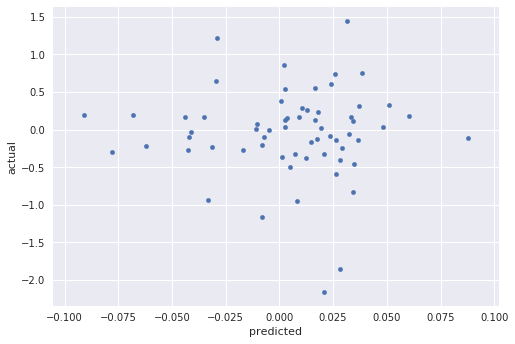

In [20]:
import scipy

train_pred = list(estimator.predict(predictors[trainsize:].values))
train_rmse = np.sqrt(np.mean(np.power((targets[trainsize:].values - train_pred), 2)))
print 'Training has RMSE of {0}'.format(train_rmse)

test_pred = list(estimator.predict(predictors[:testsize].values))
test_rmse = np.sqrt(np.mean(np.power((targets[:testsize].values - test_pred), 2)))
print 'Testing has RMSE of {0}'.format(test_rmse)

actuals = list(targets[:testsize].values)
predicted_vs_actual = pd.DataFrame.from_dict(data = 
                               {'predicted' : test_pred,
                                'actual' : actuals})
predicted_vs_actual.plot(kind='scatter', x='predicted', y='actual')

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(test_pred, actuals)
r_2 = math.pow(r_value, 2)
print 'R^2 value: of {0}'.format(r_2)

# Output Results

In [ ]:
f = open('predicted_vs_actual.csv','w')
i = 0
f.write('predicted,actual\n')
while i < len(test_pred):
  f.write('{0},{1}\n'.format(test_pred[i], actuals[i]))
  i 
f.close()